# Generative Adversarial Network: training

SOLUTION: https://www.youtube.com/watch?v=3Hq9BGbP6Dw&t=572s

In this exercise we will practice how to train a GAN on a real dataset and generate our first synthetic images. Let's get started!

First let's define some parameters for our GAN:

In [1]:
import multiprocessing

CONFIG = {
    # For repeatibility we will fix the random seed
    "manual_seed": 42,
    # This defines a set of augmentations we will perform, see below
    "policy": "color,translation",  #,cutout
    # Dimension of the latent space
    "latent_dimension": 256,
    # Batch size for training
    "batch_size": 256,
    # Number of epochs. We will use 1200 epochs which corresponds to 
    # approximately 20 min of training
    "n_epochs": 40,
    # Input images will be resized to this, the generator will generate
    # images with this size
    "image_size": 64,  # 64x64 pixels
    # Number of channels in the input images
    "num_channels": 3,  # RGB
    # Learning rate
    "lr": 0.002,
    # Momentum for Adam: in GANs you want to use a lower momentum to
    # allow the Generator and the Discriminator to interact quicker
    "beta1": 0.7,
    # Number of feature maps in each layer of the Generator
    "g_feat_map_size": 64,
    # Number of feature maps in each layer of the Discriminator
    "d_feat_map_size": 64,
    # Where to save the data
    "data_path": "/data/stanford_cars/",
    # Number of workers to use to load the data
    "workers": multiprocessing.cpu_count(),
    # We will display progress every "save_iter" epochs
    "save_iter": 10,
    # Where to save the progress
    "outdir": "stanford_cars_gan_b128",
    # Unused
    "clip_value": 0.01
}

In order to make the training repeatible, let's fix the random seed and set pytorch to use deterministic algorithms. This is normally not necessary, although it might not be a bad idea to keep your experimentation ordered. Keep in mind that the initial random seed can have quite an impact on the training of the GAN.

One thing to consider is that deterministic algorithms can be significantly slower than non-deterministic ones, so we pay a performance penalty for setting things this way. In a real training scenario you might want to reconsider this tradeoff.

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import random
import torch

random.seed(CONFIG['manual_seed'])
torch.manual_seed(CONFIG['manual_seed'])
torch.use_deterministic_algorithms(True)

Let's import a few other modules, methods and functions that we will need:

In [3]:
import argparse
import json
from pathlib import Path
from helpers import get_positive_labels
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from data import get_dataloader
from generator import Generator
from discriminator import Discriminator
from helpers import initialize_weights

from diff_augment import DiffAugment

from viz import training_tracking, visualize_batch
from IPython.display import clear_output
import matplotlib.pyplot as plt

from ema_pytorch import EMA

import time
import tqdm

# Create the output directory
output_dir = Path(CONFIG["outdir"])
output_dir.mkdir(parents=True, exist_ok=True)

# Save the configuration there for safekeeping
with open(output_dir / "config.json", "w") as f:
    json.dump(CONFIG, f, indent=4)

# Make sure CUDA is available (i.e. the GPU is setup correctly)
assert torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Input dataset: real data

In order to train a GAN we need to show it real data of the type we want to generate. In this case we are going to focus on the Car class of the CIFAR10 dataset:

Using 32 workers
Total number of examples: 16185


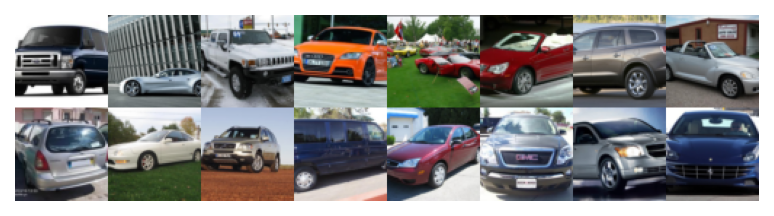

In [18]:
# Get data loader
dataloader = get_dataloader(
    CONFIG["data_path"],
    CONFIG["image_size"],
    CONFIG["batch_size"],
    CONFIG["workers"],
)
print(f"Total number of examples: {len(dataloader.dataset)}")
visualize_batch(next(iter(dataloader))[0][:16])

These are 5000 tiny images (32x32 pixels) representing cars. We will upsample them to 64x64 to make it a little easier to see the results.

## Generator
Let's create the Generator network and look at its architecture:

In [23]:
# ToDo
# YOUR CODE HERE
# Initialize models and optimizers
G = Generator(image_size=CONFIG["image_size"],latent_dimension=CONFIG["latent_dimension"],
             feat_map_size=CONFIG["d_feat_map_size"],num_channels=CONFIG["num_channels"],).to(device)

print(G)

Generator(
  (model): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2

> **Explain the architecture**: the Generator is composed of 5 blocks (from 0 to 4), represented by the `Sequential` modules. What are the blocks doing?
>    They are gradually upsampling the input latent and transforming it into an image with a shape of 3x64x64. 
> 
> The blocks use Transposed convolutions with stride 2 to gradually expand the size of the feature maps. The last block uses a Tanh activation so that the output is forced to be between -1 and 1.

Let's create a latent vector and put it through the Generator. What shape would you expect?

> **Complete the code marked by the YOUR CODE HERE placeholder**

Solution:

In [27]:
# ToDo
# YOUR CODE HERE
latent = torch.randn(1, CONFIG["latent_dimension"], 1, 1).to(device)
fake_img = G(latent)
print(fake_img.shape)

# import matplotlib 

# matplotlib.pyplot.imshow(fake_img[0].permute(1, 2, 0).detach().numpy())

torch.Size([1, 3, 64, 64])


Let's look at what the Generator is producing right now:

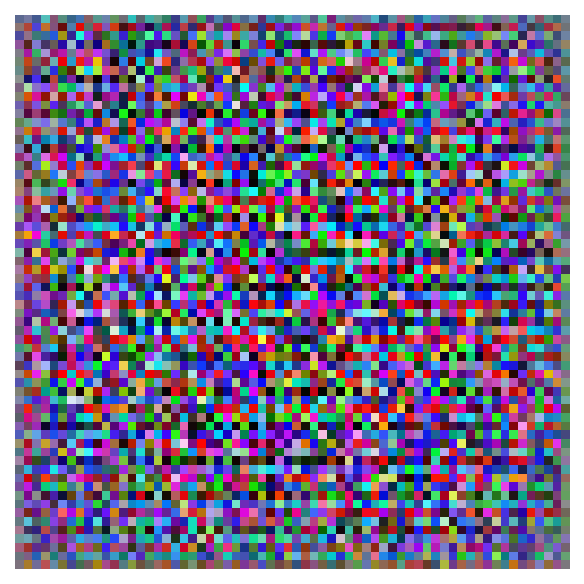

In [28]:
visualize_batch(G(latent))

This is of course just noise, because the Generator has not been trained yet. Now let's look at the shape of the tensor as it flows through the architecture:

In [29]:
x = latent
for i in range(5):
    x = G.model[i](x.cuda())
    b, c, w, h = x.shape
    
    print(f"Channels: {c:3d}, w x h: {w:2d} x {h:2d}")

Channels: 512, w x h:  4 x  4
Channels: 256, w x h:  8 x  8
Channels: 128, w x h: 16 x 16
Channels:  64, w x h: 32 x 32
Channels:   3, w x h: 64 x 64


We can see that the input latent is mapped to 512 feature maps of size 4x4 pixels. After the first convolution, we have 256 feature maps of size 8x8 pixels, and so on, until we get to 3 output channels and a size of 64x64 pixels, which is the expected size for our fake image (matching the size of the input dataset).

## Discriminator
Now let's have a look at the Discriminator:

In [30]:
D = (
    Discriminator(
        CONFIG["image_size"], CONFIG["d_feat_map_size"], CONFIG["num_channels"], dropout=0.1
    )
    .to(device)#.eval()
)

print(D)

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): Dropout(p=0.1, inplace=False)
      (2): Identity()
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Dropout(p=0.1, inplace=False)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Dropout(p=0.1, inplace=False)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Dropout

the Discriminator is composed of 5 blocks (from 0 to 4), represented by the Sequential modules. This is a standard classification CNN for Binary classification but it does not use any pooling layer. Instead, all convolutional layers are using a stride of 2 so the feature maps become smaller and smaller at every iteration:

In [31]:
x = fake_img
for i in range(5):
    x = D.model[i](x)
    b, c, w, h = x.shape
    
    print(f"Channels: {c:3d}, w x h: {w:2d} x {h:2d}")

Channels:  64, w x h: 32 x 32
Channels: 128, w x h: 16 x 16
Channels: 256, w x h:  8 x  8
Channels: 512, w x h:  4 x  4
Channels:   1, w x h:  1 x  1


## Loss and optimizers

Like in any other task involving the training of neural networks, we need to setup the loss function we want to minimize and the optimizer.

In the case of GANs, we have two optimizers: the optimizer for the Generator, and the optimizer for the Discriminator:

> **Complete the code marked by the YOUR CODE HERE placeholder**

In [37]:
# ToDo
# YOUR CODE HERE
from torch.nn import BCELoss
from torch.optim import Adam
criterion = BCELoss()

# ToDo
# YOUR CODE HERE
# Optimizer for the Generator
optimizerG = Adam(params=G.parameters(),lr=CONFIG["lr"])


# ToDo
# YOUR CODE HERE
# Optimizer for the Discriminator
optimizerD = Adam(params=G.parameters(),lr=CONFIG["lr"])

# NOTE: check solution in youtube video. The optimizers look different there. This might explain if things dont train well.

### Trick 1: Exponential Moving Average

GANs are notoriously difficult to train as the balance between the Generator and the Discriminator is easy to break. There are many tricks that can be used to stabilize that, and we're going to apply some here.

The first trick is the [Exponential Moving Average](https://arxiv.org/abs/1806.04498): while the Generator is training, we keep a moving average of its weights. At the end we use this smoothed version of the model to generate inference. This model jumps around less and it is less sensitive to sudden changes.

The EMA class accepts a parameter called beta, which controls the size of the window used for averaging. The number of steps (i.e. batches) we are going to average over is approximately equal to 1 / (1 - beta). Since there are 20 batches in our dataloader, if we use beta=0.995 we are averaging over 10 epochs:

In [38]:
ema_G = EMA(
    G,
    beta = 0.995,              # average over the last ~10 epochs
    update_after_step = 100,    # start averaging after the first 5 epochs
    update_every = 1
)

## Training loop

### Trick 2: Gaussian initialization

The original DCGAN paper suggests to initialize the weights of both G and D with a Gaussian distribution (instead of the default pytorch initialization):

In [39]:
# Initialize weights
_ = G.apply(initialize_weights)
_ = D.apply(initialize_weights)

ok, we're now ready to start training! We will use the "split-batch" technique we have seen in the lesson, where we compute separately the gradients for the Discriminator, first on a batch of real images and then on a batch of fake images. Then we accumulate the gradients and perform one backward pass. For the Generator, we adopt the trick of maximizing log(D(G(z))) instead of minimizing log(1−D(G(z))). This is accomplished by setting the labels for the fake images generated by the Generator to 1 ("real") instead of 0 ("fake"), as we have seen in the lesson.

But first let's look at some more tricks we're using in the training loop.

### Trick 3: Label smoothing

Label smoothing is a general technique originally proposed in [this paper](https://arxiv.org/abs/1512.00567) and described in detail [here](https://arxiv.org/abs/1906.02629). It consists of substituting the probability for the target class from 1 (``hard labels``) to something lower than 1. In case of Binary Classification, the BCELoss gets as input the probability for the positive class, so Label Smoothing becomes as simple as substituting 1 with a random number between 0.8 and 1.2. Label smoothing promotes less overconfidence in the Discriminator and slow down its convergence, especially at the beginning when the Generator is still pretty bad at generating realistic images.

### Trick 4: Random flipping
In order to make the work of the Discriminator a little harder and prevent it to immediately overwhelm the Generator, it is suggested to add some random noise in the labels for the Discriminator. This is equivalent to flipping some labels from positive to negative. This effectively prevents the Discriminator to ever achieve zero loss.

### Trick 5: DiffAugment
In [this](https://arxiv.org/abs/2006.10738) paper the authors introduce a simple set of augmentations to be applied on both the real and the fake images that prevent overfitting in the Discriminator. Since here we only have 5000 examples of real images, overfitting is very easy and this technique will prove very useful.

> **Complete the code marked by the YOUR CODE HERE placeholder**

In [40]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(16, CONFIG['latent_dimension'], 1, 1, device=device)

# Lists to keep track of progress
G_losses = []
D_losses = []
D_acc = []

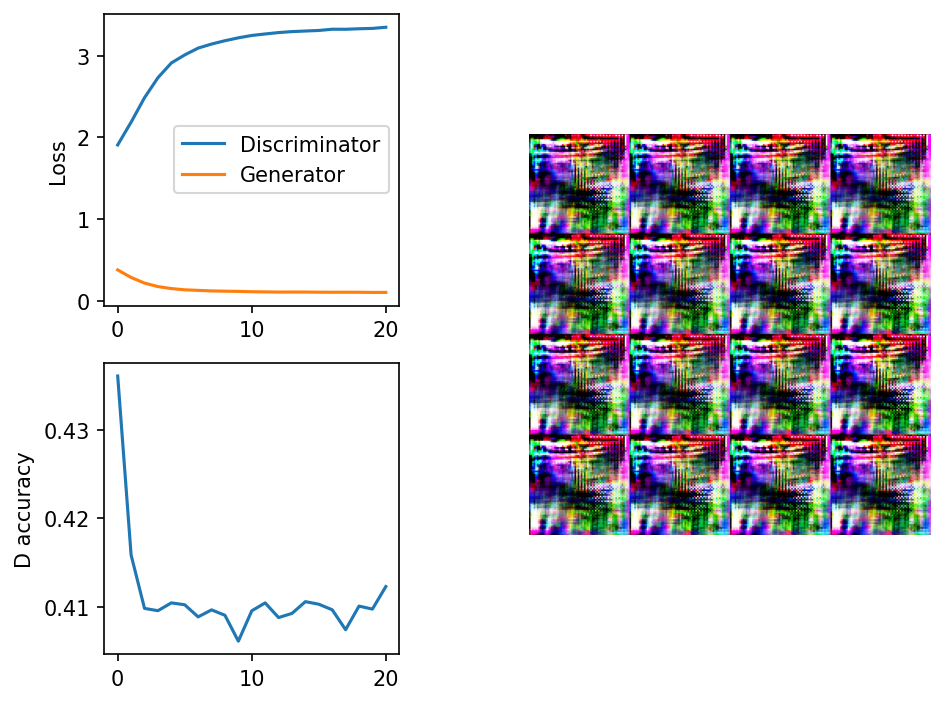

 61%|██████    | 39/64 [00:28<00:09,  2.58it/s]

In [ ]:
print("Starting Training Loop...")

tstart = time.time()
n_frame = 0

for epoch in range(CONFIG['n_epochs']):
    
    # Keep track of losses and accuracy of the Discriminator
    # for each batch, we will average them at the end of the
    # epoch
    batch_G_losses = []
    batch_D_losses = []
    batch_D_acc = []
    
    # Loop over batch of real data (we throw away the labels
    # provided by the dataloader by saving them into `_`)
    for data, _ in tqdm.tqdm(dataloader, total=len(dataloader)):
        
        # Move batch to GPU and record its size
        # (remember that the last batch could be smaller than batch_size)
        data = data.to(device)
        b_size = data.size(0)
        
        # This function implements tricks 3 and 4 (smoothing and random label flipping)
        labels = get_positive_labels(b_size, device, smoothing=True, random_flip=0.2)
        
        ################################################
        # Discriminator training                       #
        ################################################
        
        D.zero_grad()
        
        # Forward pass real batch through D using DiffAugment
        # augmentation
        D_pred = D(
            DiffAugment(data, policy=CONFIG["policy"])
        ).view(-1)

        # Measure accuracy for the positive batch
        acc_pos = (D_pred > 0.5).sum() / D_pred.size(0)

        # Loss on the real data
        
        # YOUR CODE HERE
        loss_on_real_data = criterion(D_pred, labels)
        # This computes the gradients after the real data
        # forward pass and store them in the tensors
        # (model parameters are NOT updated here)
        loss_on_real_data.backward()

        # Now pass a batch of fake data through the model
        # Generate batch of latent vectors
        latent_vectors = torch.randn(b_size, CONFIG['latent_dimension'], 1, 1, device=device)
        # Generate fake image batch with G
        fake_data = G(latent_vectors)
        # Assign negative label
        labels.fill_(0)  # 0 is the label for fake images

        # Get predictions from the Discriminator
        # (applying DiffAugment augmentations)
        # NOTE: here it is VERY important to use .detach() on the (augmented)
        # fake data because we do NOT want the Generator to be part of the computation
        # graph used to compute the gradients (we don't want to update the Generator yet)
        D_pred = D(
            DiffAugment(
                fake_data, 
                policy=CONFIG["policy"]
            ).detach()
        ).view(-1)

        # Get accuracy for this all-fake batch
        acc_neg = (D_pred < 0.5).sum() / D_pred.size(0)

        # Loss on fake data
        loss_on_fake_data = criterion(D_pred, labels)
        # This computes the gradients after the fake data
        # forward pass and stores them in the tensors
        # (model parameters are NOT updated here)
        # Remember that .backward() by default does NOT replace
        # the gradients coming from the backward pass on the real data.
        # Instead, it sums the new gradients with the old gradients
        loss_on_fake_data.backward()

        # Compute error of D as sum over the fake and the real batches
        # for safekeeping
        total_loss = loss_on_real_data + loss_on_fake_data
                
        # Now we can finally update the Discriminator
        optimizerD.step()

        ################################################
        # Generator training                           #
        ################################################
        G.zero_grad()
        
        # YOUR CODE HERE
        
        # Remember that BCELoss is −[y logx + (1−y)⋅log(1−x)]
        labels.fill_(1)  # 1 is the label for "real".
        # Since we just updated D, perform another forward pass of
        # the all-fake batch we already generated as part of the previous
        # part (with DiffAugment)
        # NOTE how we are NOT using .detach now, as this time we want the
        # gradients for this operation to be accumulated
        D_pred = D(
            DiffAugment(
                fake_data, 
                policy=CONFIG["policy"]
            )
        ).view(-1)
        
        # Loss from the Discriminator prediction that is going
        # to be used to update G
        loss_on_fake_G = criterion(D_pred, labels)
        
        # Calculate gradients for G
        loss_on_fake_G.backward()
                
        # Update G
        optimizerG.step()
        
        # Update the Exponential Moving Average copy
        ema_G.update()
        
        # Save all losses
        batch_G_losses.append(loss_on_fake_G.item())
        batch_D_losses.append(total_loss.item())
        batch_D_acc.append((0.5 * (acc_pos + acc_neg)).item())
    
    # Take the mean over the epoch
    G_losses.append(np.mean(batch_G_losses))
    D_losses.append(np.mean(batch_D_losses))
    D_acc.append(np.mean(batch_D_acc))

    if epoch % CONFIG["save_iter"] == 0:
        with torch.no_grad():
            fake_viz_data = G(fixed_noise).detach().cpu()

        clear_output(wait=True)

        fig = training_tracking(D_losses, G_losses, D_acc, fake_viz_data)

        plt.show()
        
        fig.savefig(f"{CONFIG['outdir']}/frame_{n_frame:05d}.png")
        n_frame += 1

print(f"Finished in {(time.time() - tstart)/60:.1f} min")

In [ ]:
visualize_batch(ema_G(fixed_noise).detach().cpu())

If we were to let it run for say 300 epochs, than this is what we would get:

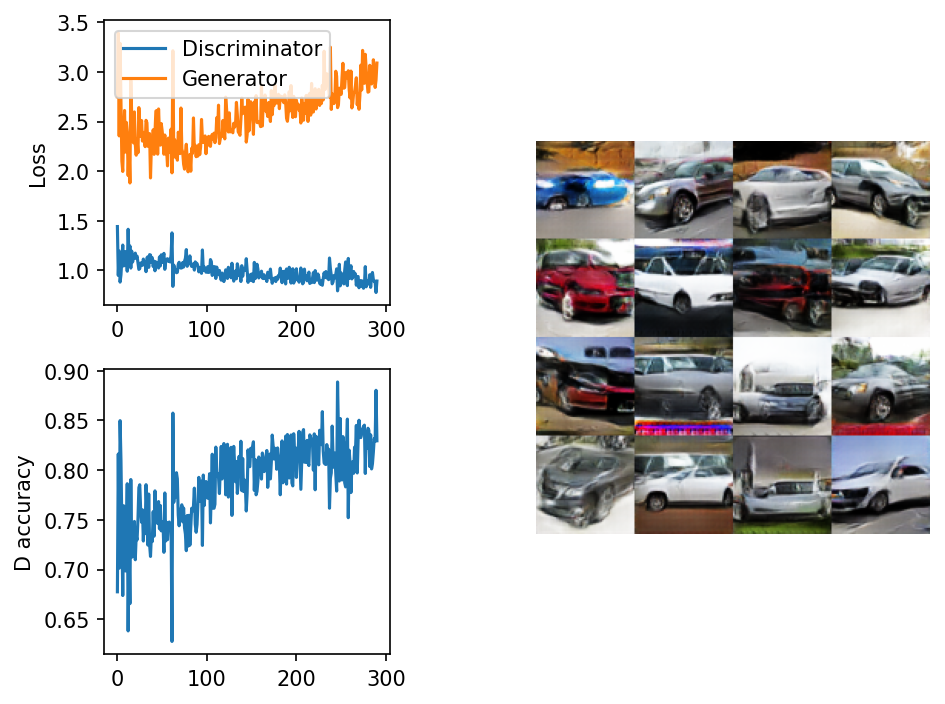

Cars start to really appear, although we would probably need quite a bit more training (and parameter tuning) to make it really work!